# Problem 2 (Value iteration)
*(This problem is adapted from Stanford AA203 course)*

In this problem, you will implement value iteration to compute the value function for a rescue drone that needs to deliver aid to a goal state while avoiding regions with fire and uncertain wind conditions.

The world is represented as an $n \times n$ grid, i.e., the state space is

$$ \mathcal{S}  := \lbrace(x_1, x_2) \in \mathbb{Z}_+^2 \mid | x_1, x_2 \in \lbrace 0, 1 . . . , n − 1\rbrace\rbrace \cup \lbrace (\texttt{None}, \texttt{None}) \rbrace, .$$

In these coordinates, $(0, 0)$ represents the bottom left corner of the map and $(n−1, n−1)$ represents the top right corner of the map. While $(\texttt{None}, \texttt{None})$ is a terminal state. For any non-terminal state, from any location $x = (x_1, x_2) \in \mathcal{S}$, the drone has four possible directions it can move in, i.e.,

$$ \mathcal{A}:= \lbrace \texttt{up}, \texttt{down}, \texttt{left}, \texttt{right} \rbrace.$$

The corresponding state changes for each action are:
- $\texttt{up}: (x_1, x_2) \mapsto (x_1, x_2+1)$ 
- $\texttt{down}: (x_1, x_2) \mapsto (x_1, x_2-1)$ 
- $\texttt{left}: (x_1, x_2) \mapsto (x_1-1, x_2)$ 
- $\texttt{right}: (x_1, x_2) \mapsto (x_1+1, x_2)$ 

There is a storm centered at $x_\mathrm{eye} \in \mathcal{S}$. The storm’s influence is strongest at its center and decays farther from the center according to the equation 

$$ \omega(x) = \exp\biggl( -\frac{\| x - x_\mathrm{eye}\|_2^2}{2\sigma^2}\biggr)$$

Given its current state $x$ and action $a$, the drone’s next state is determined as follows:
- With probability $\omega(x)$, the storm will cause the drone to move in a uniformly random direction.
- With probability $1 − \omega(x)$, the drone will move in the direction specified by the action.
- If the resulting movement would cause the drone to leave $\mathcal{S}$, then it will not move at all. For example, if the drone is on the right boundary of the map, then moving right will do nothing.
- If the drone reaches the goal state, then the drone will always transition to a *terminal state* $(\texttt{None}, \texttt{None}).$ Once in the terminal state, the drone remains in that state indefinitely regardless of the action taken.

The drone's objective is to reach $x_\mathrm{goal} \in \mathcal{S}$. If the drone reaches the goal state, then it receives a reward of $r_\mathrm{goal}$ (successfully delivers aid), and a reward of $r_\mathrm{travel}$ otherwise (cost of traveling one unit). Additionally, there are some states where there is a fire. If the drone reaches a state where there is a fire, then it receives a reward of $r_\mathrm{fire}$ (drone suffers damage). Once the drone is in the terminal state, it receives zero reward (i.e., mission has terminated). The reward of a trajectory in this infinite horizon problem is a discounted sum of the rewards earned in each timestep, with discount factor $\gamma \in (0, 1)$.

To find the optimal policy to reach the goal state from any starting location, we perform value iteration. Recall that the value iteration repeats the Bellman update until convergence.

$$ V(x) \leftarrow \max_{a\in\mathcal{A}} \biggl( \sum_{x^\prime \in \mathcal{S}} p(x, a, x^\prime) (R(x^\prime) + \gamma V(x^\prime))\biggr) $$

## (a) Problem set up
Below are some helper functions. Some are filled in, others you will you need to fill in yourself.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import functools

def is_terminal_state(state):
    """
    Check if the state is a terminal state.
    Args:
        state: Current state (row, column).
    Returns:
        True if the state is terminal, False otherwise.
    """
    return state == (None, None)


def _state_space(max_rows, max_columns):
    return [(i, j) for i in range(max_rows) for j in range(max_columns)] + [(None, None)]


def _reward(state, fire_states, goal_states, fire_value, goal_value, travel_value):
    """
    Reward function for the grid world.
    Args:
        state: Current state (row, column).
        fire_states: List or set of fire states.
        goal_states: List or set of goal states.
        fire_value: Reward value for fire states.
        goal_value: Reward value for goal states.
    Returns:
        Reward value for the current state.
    """
    #### FILL CODE HERE ####
    # check the fire state 
    if is_terminal_state(state):
        return 0
    if state in fire_states:
        return fire_value
    if state in goal_states:
        return goal_value
    return travel_value
    # UPDATE THIS LINE
    ########################
    
def _transition_function(s, a, w=0, 
                        max_rows=20, # number of rows
                        max_columns=20, # number of columns
                        goal_states=set([]), 
                        action_set=["down", "right", "up", "left"]):
    """
    Transition function for the grid world.
    Args:
        s: Current state (row, column).
        a: Action to take.
        w: Probability of taking the action.
        max_rows: Number of rows in the grid.
        max_columns: Number of columns in the
            grid.
        action_set: List of possible actions.
    Returns:
        New state after taking the action.
    """
    i,j = s
    if is_terminal_state(s) or (s in goal_states):
        return (None, None)
    if (np.random.rand(1) < w)[0]:
        a = np.random.choice(action_set)
    if a == "up":
        return (min(i+1, max_rows-1), j)
    if a == "right":
        return (i, min(j+1, max_columns-1))
    if a == "down":
        return (max(i-1, 0), j)
    if a == "left":
        return (i, max(j-1, 0))

    
def _compute_omega_probability(state, storm_eye, storm_sigma):
    """
    Computes the probability of a state being affected by a storm.
    Args:
        state: Current state (row, column).
        storm_eye: Center of the storm (row, column).
        storm_sigma: Standard deviation of the storm.
    Returns:
        Probability of the state being affected by the storm.
    """
    if is_terminal_state(state):
        return 0
    return np.exp(-((state[0] - storm_eye[0])**2 + (state[1] - storm_eye[1])**2) / (2 * storm_sigma**2))

## (b) Problem set up (continued)

Below are the problem parameters:
- grid size $20 \times 20$
- $x_\mathrm{eye}=(10,6)$,$\: \sigma = 10$
- $\mathcal{S}_\mathrm{goal} = \lbrace (19,9) \rbrace$
- $\mathcal{S}_\mathrm{fire} = \lbrace (10,10), (11,10), (10,11), (11,11), (13, 4), (13, 5), (14, 4), (14, 5) \rbrace$
- $\gamma = 0.95$
- $r_\mathrm{fire} = -200$
- $r_\mathrm{goal} = 100$
- $r_\mathrm{travel} = -1$

Also, there are some helper functions. Some are filled in, others you will you need to fill in yourself.

In [2]:
# problem set up
max_rows, max_columns = 20, 20
fire_states = set([(10,10), (11,10), (10,11), (11,11), (13, 4), (13, 5), (14, 4), (14, 5)])
storm_eye = (10, 6)
storm_sigma = 10
goal_states = set([(19,9)])
gamma = 0.95
fire_value = -200
goal_value = 100
travel_value = -1
action_set=["down", "right", "up", "left"]


left_edge = set([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19)])
right_edge = set([(19, 0), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (19, 8), (19, 9), (19, 10), (19, 11), (19, 12), (19, 13), (19, 14), (19, 15), (19, 16), (19, 17), (19, 18), (19, 19)])
top_edge = set([(0, 19), (1, 19), (2, 19), (3, 19), (4, 19), (5, 19), (6, 19), (7, 19), (8, 19), (9, 19), (10, 19), (11, 19), (12, 19), (13, 19), (14, 19), (15, 19), (16, 19), (17, 19), (18, 19), (19, 19)])
bottom_edge = set([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0)])

# fix the problem parameters in the functions to avoid passing them every time
state_space = functools.partial(_state_space, max_rows=max_rows, max_columns=max_columns)
reward = functools.partial(_reward, fire_states=fire_states, goal_states=goal_states, fire_value=fire_value, goal_value=goal_value, travel_value=-1)
transition_function = functools.partial(_transition_function, max_rows=max_rows, max_columns=max_columns, goal_states=goal_states, action_set=action_set)
compute_omega_probability = functools.partial(_compute_omega_probability, storm_eye=storm_eye, storm_sigma=storm_sigma)


In [3]:
def probability_function(state, action, next_state, w, 
                          action_set=["down", "right", "up", "left"]):
    """
    Computes the probability of transitioning to a next state given the current state and action.
    Args:
        state: Current state (row, column).
        action: Action to take.
        next_state: Next state (row, column).
        w: Probability of taking random action.
        action_set: List of possible actions.
    Returns:
        Probability of transitioning to the next state.
    """
    
    #### FILL CODE HERE ####
    # HINT: Our solution takes ~3 lines of code
    # Reasoning: we don't know where we will end up in next state becuase there is a random 
    # disturbance centered at the map. with probability of 1-w we will reach
    # the desired state, specified by the action. what is the probability of 
    # transitiong to other states? this will be answered by this function. 
    # Compute the next state for the intended action
    if is_terminal_state(state):
        return 1.0 if next_state == (None, None) else 0.0

    if state in goal_states:
        return 1.0 if next_state == (None, None) else 0.0

    intended_state = transition_function(state, action, w=0)
    random_states = [transition_function(state, a, w=0) for a in action_set]

    prob = 0.0
    if next_state == intended_state:
        prob += 1 - w
    count = sum(1 for s in random_states if s == next_state)
    prob += w * (count / len(action_set))
    return prob
    #################

def get_possible_next_states(state, action_set):
    """
    Returns the set of possible next states given the current state.
    Args:
        state: Current state (row, column).
    Returns:
        Set of possible next states.
    """
    return set([transition_function(state, action, w=0) for action in action_set])

def is_valid(state, max_rows=20, max_columns=20):
    if state is None or state == (None, None):
        return False
    i, j = state
    return 0 <= i < max_rows and 0 <= j < max_columns

def bellman_update(value_tuple, gamma, action_set):
    """
    Performs a Bellman update on the value function.
    Args:
        value_tuple: Current value function. A tuple of (value, value_terminal).
        value: Array representing the value at each state in the grid
        value_terminal: Value of the terminal state.
        gamma: Discount factor.
        action_set: List of possible actions.
    Returns:
        Updated value_tuple and policy as a dictionary.
    """
    #### FILL CODE HERE ####
    V, V_terminal = value_tuple
    V_new = np.zeros_like(V)
    policy = {}

    for state in state_space():
        if is_terminal_state(state):
            continue

        best_action_value = float('-inf')
        best_action = None

        for action in action_set:
            total = 0.0
            next_states = get_possible_next_states(state, action_set)
            for next_state in next_states:
                w = compute_omega_probability(state)
                prob = probability_function(state, action, next_state, w=w, action_set=action_set)
                if is_terminal_state(next_state):
                    val = V_terminal
                else:
                    val = V[next_state]
                total += prob * (reward(next_state) + gamma * val)

            if total > best_action_value:
                best_action_value = total
                best_action = action

        V_new[state] = best_action_value
        policy[state] = best_action

    return (V_new, V_terminal), policy
    ########################

        
def simulate(start_state, policy, num_steps):
    """
    Simulates the agent's trajectory in the grid world.
    Args:
        start_state: Starting state (row, column).
        policy: Policy to follow.
        num_steps: Number of steps to simulate.
    Returns:
        List of states visited during the simulation.
    """
    states = [start_state]
    for _ in range(num_steps):
        action = policy[start_state]
        w = compute_omega_probability(start_state)
        next_state = transition_function(start_state, action, w=w)
        if is_terminal_state(next_state):
            break
        start_state = next_state
        states.append(start_state)
    return states

## (c) Value iteration
With all the building blocks all completed, you are ready to perform value iteration!
Below is the value iteration loop, simulating the policy, and corresponding visualization.
Run the code and visualize the results and get some intuition into how the value function changes over the iterations.

Then explore how the value and policy changes as you change different problem parameters.
Share some insights/findings based on your exploration. Do these insights/findings align with your understanding?


Reducing the number of iterations will lead to suboptimal policy. 
Changing the intial start point, i.e. mainly away from the storm leads to a more optimal policy.
Moreover changing the intensity of the storm has the effect of changing the value function, i.e. the more intense the storm, the less optimal the policy.

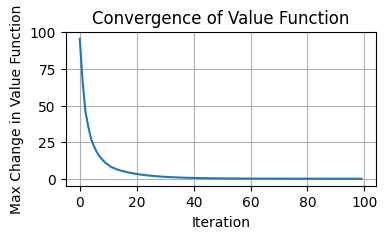

In [4]:
# Initialize the value function
V = (np.zeros([max_rows, max_columns]), 0)
# keep list of value functions
Vs = [V]
dV = []
num_iterations = 100 # feel free to change this value as needed
for itr in range(num_iterations):
    # perform Bellman update
    V_new, policy = bellman_update(V, gamma, action_set)
    # store the new value function
    Vs.append(V_new)
    dV.append(np.abs(V_new[0] - V[0]).max())
    # check for convergence
    if np.abs(V_new[0] - V[0]).max() < 1e-3:
        print("Converged!")
        break
    # update the value function
    V = V_new
    
start_state = (3,9) # pick a starting state
num_steps = 200 # feel free to change this value as needed
# simulate the trajectory
trajectory = simulate(start_state, policy, num_steps)

plt.figure(figsize=(4,2))
plt.plot(dV)
plt.title('Convergence of Value Function')
plt.xlabel('Iteration')
plt.ylabel('Max Change in Value Function')
plt.grid()

In [5]:
def plot_policy(policy):
    for (row, col), action in policy.items():
        if row is None or col is None:
            continue
        if action == "up":
            plt.text(col + 0.5, row + 0.5, '↑', ha='center', va='center', color='black', fontsize=8)
        elif action == "down":
            plt.text(col + 0.5, row + 0.5, '↓', ha='center', va='center', color='black', fontsize=8)
        elif action == "left":
            plt.text(col + 0.5, row + 0.5, '←', ha='center', va='center', color='black', fontsize=8)
        elif action == "right":
            plt.text(col + 0.5, row + 0.5, '→', ha='center', va='center', color='black', fontsize=8)


# compute the storm strength for each state for plotting later
storm_strength = np.zeros([max_rows, max_columns])
for state in state_space():
    if not is_terminal_state(state):
        storm_strength[state] = compute_omega_probability(state)
    

In [6]:
# visualize the value function and storm strength
@interact(iteration=(0,len(Vs)-1, 1), t=(0,len(trajectory)-1, 1))
def plot_value_function(iteration, t):
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.imshow(Vs[iteration][0], origin='lower', extent=[0, max_columns, 0, max_rows], cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Value Function')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(ticks=np.arange(0.5, max_columns, 1), labels=np.arange(0, max_columns))
    plt.yticks(ticks=np.arange(0.5, max_rows, 1), labels=np.arange(0, max_rows))
    plt.scatter(storm_eye[1] + 0.5, storm_eye[0] + 0.5, c='cyan', s=100, label='Storm Eye')
    for fire_state in fire_states:
        plt.scatter(fire_state[1] + 0.5, fire_state[0] + 0.5, c='red', s=100)
    plt.scatter(fire_state[1] + 0.5, fire_state[0] + 0.5, c='red', s=100, label='Fire State')
    for goal_state in goal_states:
        plt.scatter(goal_state[1] + 0.5, goal_state[0] + 0.5, c='green', s=100, label='Goal State')
        
    # Overlay the policy
    plot_policy(policy)
    # Plot the trajectory
    trajectory_x = [state[1] + 0.5 for state in trajectory]
    trajectory_y = [state[0] + 0.5 for state in trajectory]
    plt.plot(trajectory_x, trajectory_y, color='orange', label='Trajectory', linewidth=2)
    plt.scatter(trajectory_x[t], trajectory_y[t], color='orange', s=100, label='Current State')
    plt.legend(loc="lower left", framealpha=0.6)
    
    plt.subplot(1, 2, 2)
    plt.imshow(storm_strength, origin='lower', extent=[0, max_columns, 0, max_rows], cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Storm Strength')
    plt.title('Storm Strength')
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.xticks(ticks=np.arange(0.5, max_columns, 1), labels=np.arange(0, max_columns))
    plt.yticks(ticks=np.arange(0.5, max_rows, 1), labels=np.arange(0, max_rows))
    plt.show()

interactive(children=(IntSlider(value=50, description='iteration'), IntSlider(value=33, description='t', max=6…